# Boosting이란 무엇인가?

### Boosting은

> 여러 개의 약한 학습기(Weak Learner) 를
순차적으로 학습시켜
이전 모델의 실수를 다음 모델이 보완하도록 만드는 앙상블 기법

### 핵심 특징

- 순차적 학습 (병렬 ❌)

- 이전 모델의 에러 정보 활용

- 주로 편향(Bias) 감소 목적

# AdaBoost (Adaptive Boosting)란?

AdaBoost는 Boosting의 가장 기본이자 원형인 알고리즘

>틀린 데이터의 가중치를 높여
다음 모델이 그 데이터를 더 집중해서 학습하도록 만드는 방식

# AdaBoost의 핵심 아이디어 3가지
1. 데이터(샘플) 가중치

  - 처음엔 모든 데이터 중요도 동일

  - 틀린 데이터 → 가중치 ↑

  - 맞춘 데이터 → 가중치 ↓

👉 아직 설명되지 않은 패턴에 집중


2. 모델 가중치 (α)

  - 각 약한 학습기는 성능에 따라 다른 영향력을 가짐

  - 오류율이 낮을수록 α ↑

  - 랜덤 수준(error = 0.5)이면 α = 0 → 의미 없음

3. 가중 투표로 최종 예측

> H(x)=sign(∑αt​ht​(x))

# AdaBoost의 장점과 단점
### ✅ 장점

- 구조가 단순하고 직관적

- 적은 데이터에서도 성능 좋음

- 앙상블 개념 이해에 최적

### ❌ 단점

- 노이즈/이상치에 약함

  - 계속 틀리면 가중치가 과도하게 커짐

- 순차 학습 → 속도 느림

- 병렬 처리 어려움

## AdaBoost 핵심 구조
```
초기화
for t in T:
    약한 모델 학습
    오류율 계산
    모델 가중치 α 계산
    샘플 가중치 업데이트
최종 예측 = 가중 투표
```

# Ada Boost 구현

sklearn에서 앙상블의 AdaBoostClassifier를 임포트 하여 사용해도 되지만
간단하게 구현해보자




###1. 의사결정 스텀프 구현

In [1]:
import numpy as np

class DecisionStump:
    def __init__(self):
        self.feature_idx = None
        self.threshold = None
        self.polarity = 1  # 방향 (+1 or -1)

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)

        if self.polarity == 1:
            predictions[X[:, self.feature_idx] < self.threshold] = -1
        else:
            predictions[X[:, self.feature_idx] >= self.threshold] = -1

        return predictions

### 2. Ada Boost 구현


In [2]:
class AdaBoost:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.ones(n_samples) / n_samples  # 초기 가중치

        for _ in range(self.n_estimators):
            stump = DecisionStump()
            min_error = float("inf")

            # 모든 feature + threshold 탐색
            for feature_idx in range(n_features):
                thresholds = np.unique(X[:, feature_idx])

                for threshold in thresholds:
                    for polarity in [1, -1]:
                        predictions = np.ones(n_samples)
                        if polarity == 1:
                            predictions[X[:, feature_idx] < threshold] = -1
                        else:
                            predictions[X[:, feature_idx] >= threshold] = -1

                        error = np.sum(w[y != predictions])

                        if error < min_error:
                            min_error = error
                            stump.feature_idx = feature_idx
                            stump.threshold = threshold
                            stump.polarity = polarity

            # 모델 가중치 α
            eps = 1e-10
            alpha = 0.5 * np.log((1 - min_error + eps) / (min_error + eps))

            # 샘플 가중치 업데이트
            predictions = stump.predict(X)
            w *= np.exp(-alpha * y * predictions)
            w /= np.sum(w)  # 정규화

            self.models.append(stump)
            self.alphas.append(alpha)

    def predict(self, X):
        model_preds = np.array([
            alpha * model.predict(X)
            for model, alpha in zip(self.models, self.alphas)
        ])
        return np.sign(np.sum(model_preds, axis=0))


### 3. 임의의 데이터 생성 후 간단한 테스트

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터 생성
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    random_state=42
)

# 라벨을 {-1, +1}로 변환
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# AdaBoost 학습
model = AdaBoost(n_estimators=10)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.8833333333333333


### 4. sklearn Ada Boost 와 비교

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

sk_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=10
)

sk_model.fit(X_train, (y_train + 1) // 2)
sk_pred = sk_model.predict(X_test)

print("sklearn Accuracy:", accuracy_score((y_test + 1) // 2, sk_pred))


sklearn Accuracy: 0.8833333333333333


# Will Pigeon Eat Bun? 데이터셋 실습

### 데이터 로드

확인 포인트

- 결측치 없음

- 전부 수치형

- 합성 데이터라 전처리 거의 필요 없음

In [5]:
import pandas as pd
import numpy as np

# Kaggle에서 다운받은 csv 업로드 후 경로 맞추기
train_df = pd.read_csv("/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼/비둘기/train_bun.csv")
test_df = pd.read_csv("/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼/비둘기/test_bun.csv")

train_df.head()

,id,bun_size,nearby_pigeons_count,time_of_day,feeding_spot_popularity,distance_to_pigeons_m,is_raining,crumbs_on_ground,crowd_density,human_distance_m,noise_level,will_eat_bun
0,2099,2.117397,5,11,5.183150,7.780918,0,5.472407,5,1.074004,10,0
1,1332,1.850617,5,17,4.595100,3.644349,1,2.290217,2,3.159703,1,1
2,569,1.575189,1,9,1.810567,2.309359,0,3.719027,1,3.762946,1,0
3,599,0.790015,8,12,8.548308,5.182641,1,5.983987,10,1.948632,5,0
4,1050,1.003298,4,19,4.046106,2.514642,0,3.413828,0,2.363299,10,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2000 non-null   int64  
 1   bun_size                 2000 non-null   float64
 2   nearby_pigeons_count     2000 non-null   int64  
 3   time_of_day              2000 non-null   int64  
 4   feeding_spot_popularity  2000 non-null   float64
 5   distance_to_pigeons_m    2000 non-null   float64
 6   is_raining               2000 non-null   int64  
 7   crumbs_on_ground         2000 non-null   float64
 8   crowd_density            2000 non-null   int64  
 9   human_distance_m         2000 non-null   float64
 10  noise_level              2000 non-null   int64  
 11  will_eat_bun             2000 non-null   int64  
dtypes: float64(5), int64(7)
memory usage: 187.6 KB


In [7]:
 test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       500 non-null    int64  
 1   bun_size                 500 non-null    float64
 2   nearby_pigeons_count     500 non-null    int64  
 3   time_of_day              500 non-null    int64  
 4   feeding_spot_popularity  500 non-null    float64
 5   distance_to_pigeons_m    500 non-null    float64
 6   is_raining               500 non-null    int64  
 7   crumbs_on_ground         500 non-null    float64
 8   crowd_density            500 non-null    int64  
 9   human_distance_m         500 non-null    float64
 10  noise_level              500 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 43.1 KB


In [8]:
train_df.describe()

,id,bun_size,nearby_pigeons_count,time_of_day,feeding_spot_popularity,distance_to_pigeons_m,is_raining,crumbs_on_ground,crowd_density,human_distance_m,noise_level,will_eat_bun
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1256.017000,1.478209,6.062000,14.171000,4.942930,4.049591,0.146500,3.158775,5.041000,2.032174,4.964500,0.601500
std,718.292699,0.401951,2.487619,3.734532,2.391180,1.921703,0.353695,1.929766,3.166596,0.955717,3.138497,0.489712
min,0.000000,0.500000,0.000000,8.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000
25%,632.750000,1.205846,4.000000,11.000000,3.251157,2.659433,0.000000,1.725328,2.000000,1.365545,2.000000,0.000000
50%,1265.000000,1.495119,6.000000,14.000000,4.953495,4.020582,0.000000,3.109481,5.000000,2.025630,5.000000,1.000000
75%,1876.250000,1.741381,8.000000,17.000000,6.645467,5.356736,0.000000,4.502067,8.000000,2.663217,8.000000,1.000000
max,2499.000000,2.665698,18.000000,20.000000,10.000000,10.177024,1.000000,9.404652,10.000000,5.327472,10.000000,1.000000


### 타겟 분포 확인

In [9]:
train_df['will_eat_bun'].value_counts(normalize=True)

,proportion
will_eat_bun,
1,0.6015
0,0.3985


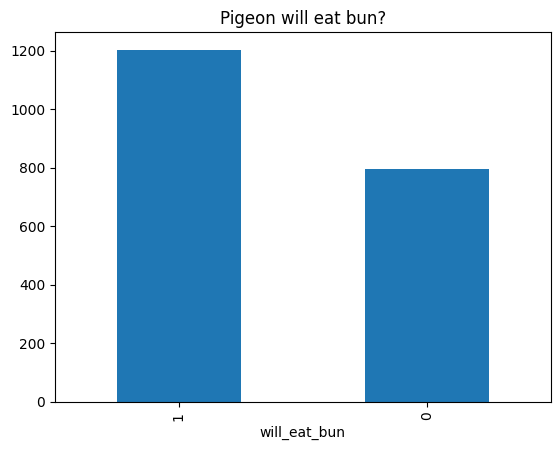

In [10]:
import matplotlib.pyplot as plt

train_df['will_eat_bun'].value_counts().plot(kind='bar')
plt.title("Pigeon will eat bun?")
plt.show()

In [11]:
X = train_df.drop(columns=['will_eat_bun'])
y = train_df['will_eat_bun']

### Train / Validation 분

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### AdaBoost 적용

In [48]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

ada = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)

ada.fit(X_train, y_train)

ada_pred = ada.predict(X_test)
ada_proba = ada.predict_proba(X_test)[:,1]

print("AdaBoost Accuracy:", accuracy_score(y_test, ada_pred))
print("AdaBoost AUC:", roc_auc_score(y_test, ada_proba))

AdaBoost Accuracy: 0.8725
AdaBoost AUC: 0.9560009394817193


### 단계별 분류기 확인

In [49]:
len(ada.estimators_)

100

In [50]:
ada.estimator_weights_[:10]

array([0.44921072, 0.3922869 , 0.22640594, 0.3360628 , 0.2734991 ,
       0.27961165, 0.17058663, 0.24031546, 0.14615009, 0.22046784])

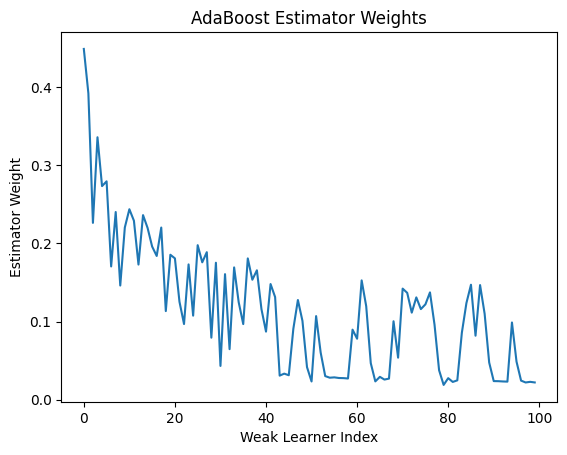

In [51]:
plt.plot(ada.estimator_weights_)
plt.xlabel("Weak Learner Index")
plt.ylabel("Estimator Weight")
plt.title("AdaBoost Estimator Weights")
plt.show()

### 틀린 샘플 확인
틀린 샘플은 다음 트리에서 가중치를 올림.

In [52]:
test_df = X_test.copy()
test_df['true'] = y_test.values
test_df['pred'] = ada_pred

wrong_samples = test_df[test_df['true'] != test_df['pred']]
wrong_samples.head()

,id,bun_size,nearby_pigeons_count,time_of_day,feeding_spot_popularity,distance_to_pigeons_m,is_raining,crumbs_on_ground,crowd_density,human_distance_m,noise_level,true,pred
1970,2101,0.814206,7,19,5.190489,4.088278,0,0.931333,9,1.836145,6,0,1
1701,1117,1.355492,6,16,1.871060,2.597312,0,5.842617,9,2.386879,9,0,1
361,257,1.349538,5,17,5.766328,4.663083,0,2.634307,3,0.673086,9,0,1
1456,1341,1.671119,12,8,1.453599,3.824145,0,2.760683,5,0.746230,8,1,0
260,934,1.623848,5,13,2.478548,1.441492,0,2.103205,4,2.165219,9,0,1


### 과적합

In [26]:
train_acc = []
test_acc = []

ada = AdaBoostClassifier(
    n_estimators=300,
    learning_rate=0.5,
    random_state=42
)
ada.fit(X_train, y_train)

for y_tr_pred, y_test_pred in zip(
    ada.staged_predict(X_train),
    ada.staged_predict(X_test)
):
    train_acc.append(accuracy_score(y_train, y_tr_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


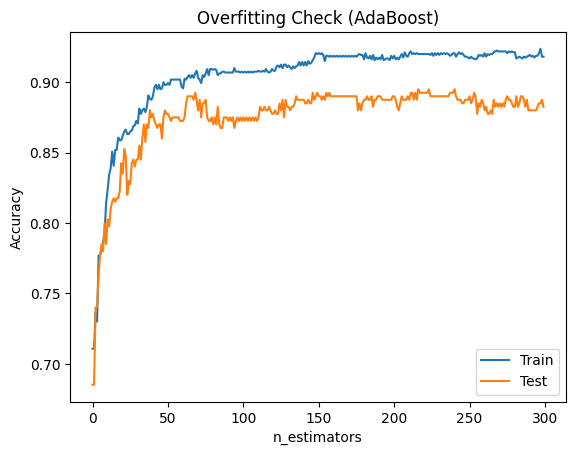

In [27]:
plt.plot(train_acc, label="Train")
plt.plot(test_acc, label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Overfitting Check (AdaBoost)")
plt.show()

### GBM
특징

- AdaBoost보다 안정적

- learning_rate 작게 + n_estimators 크게

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gbm.fit(X_train, y_train)

gbm_pred = gbm.predict(X_test)
gbm_proba = gbm.predict_proba(X_test)[:, 1]

print("[GBM]")
print("Accuracy:", accuracy_score(y_test, gbm_pred))
print("AUC:", roc_auc_score(y_test, gbm_proba))


[GBM]
Accuracy: 0.9
AUC: 0.9628904720895639


###LightGBM
특징

- 히스토그램 기반 → 속도 빠름

- 데이터 커질수록 강함

In [54]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm.fit(X_train, y_train)

lgbm_pred = lgbm.predict(X_test)
lgbm_proba = lgbm.predict_proba(X_test)[:, 1]

print("[LightGBM]")
print("Accuracy:", accuracy_score(y_test, lgbm_pred))
print("AUC:", roc_auc_score(y_test, lgbm_proba))


[LightGBM] [Info] Number of positive: 962, number of negative: 638
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.601250 -> initscore=0.410676
[LightGBM] [Info] Start training from score 0.410676
[LightGBM]
Accuracy: 0.875
AUC: 0.9569143244865472


### XGBoost
특징

- 정규화 + subsampling → 과적합 억제

In [55]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
xgb_proba = xgb.predict_proba(X_test)[:, 1]

print("[XGBoost]")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("AUC:", roc_auc_score(y_test, xgb_proba))


[XGBoost]
Accuracy: 0.8925
AUC: 0.9633080195203423


In [56]:
results = pd.DataFrame({
    "Model": ["AdaBoost", "GBM", "XGBoost", "LightGBM"],
    "Accuracy": [
        accuracy_score(y_test, ada.predict(X_test)),
        accuracy_score(y_test, gbm_pred),
        accuracy_score(y_test, xgb_pred),
        accuracy_score(y_test, lgbm_pred)
    ],
    "AUC": [
        roc_auc_score(y_test, ada.predict_proba(X_test)[:,1]),
        roc_auc_score(y_test, gbm_proba),
        roc_auc_score(y_test, xgb_proba),
        roc_auc_score(y_test, lgbm_proba)
    ]
})

results


,Model,Accuracy,AUC
0,AdaBoost,0.8725,0.956001
1,GBM,0.9000,0.962890
2,XGBoost,0.8925,0.963308
3,LightGBM,0.8750,0.956914
